# 01 - Data Acquisition and Overview

This notebook explores the smart contract vulnerability dataset and provides comprehensive analysis of the available data.

**Goals:**
- Load and explore the dataset structure
- Analyze vulnerability categories and distribution
- Examine contract files and their characteristics
- Understand bug logs and analysis results
- Generate comprehensive data statistics
- Create visualizations for data understanding

## 1. Import Libraries and Setup

In [6]:
import sys
import os
from pathlib import Path

# Add parent directory to path for imports
parent_dir = Path().absolute().parent
sys.path.append(str(parent_dir))

# Data manipulation and analysis
import pandas as pd
import numpy as np
import json
import glob
import re
from collections import Counter, defaultdict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Utilities
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Libraries imported successfully!")
print(f"📁 Working directory: {os.getcwd()}")

✅ Libraries imported successfully!
📁 Working directory: /home/virtualvasu/Desktop/sem5/ml_project/smart-contract-vuln-detector/notebooks


## 2. Dataset Structure Exploration

In [7]:
# Define dataset paths
dataset_root = Path("../dataset")
buggy_contracts_dir = dataset_root / "buggy_contracts"
results_dir = dataset_root / "results"

print("="*60)
print("DATASET STRUCTURE OVERVIEW")
print("="*60)

# Check if paths exist
print(f"Dataset root exists: {dataset_root.exists()}")
print(f"Buggy contracts dir exists: {buggy_contracts_dir.exists()}")
print(f"Results dir exists: {results_dir.exists()}")

if not dataset_root.exists():
    print("❌ Dataset directory not found!")
    print("Please ensure the dataset is in the correct location.")
else:
    print("✅ Dataset directory found!")

DATASET STRUCTURE OVERVIEW
Dataset root exists: True
Buggy contracts dir exists: True
Results dir exists: True
✅ Dataset directory found!


In [8]:
# Explore vulnerability categories
vulnerability_categories = []
if buggy_contracts_dir.exists():
    vulnerability_categories = [d.name for d in buggy_contracts_dir.iterdir() if d.is_dir()]
    
print("📊 VULNERABILITY CATEGORIES")
print("="*40)
for i, category in enumerate(vulnerability_categories, 1):
    print(f"{i:2d}. {category}")

print(f"\n📈 Total Categories: {len(vulnerability_categories)}")

📊 VULNERABILITY CATEGORIES
 1. TOD
 2. Unhandled-Exceptions
 3. Overflow-Underflow
 4. Unchecked-Send
 5. Timestamp-Dependency
 6. tx.origin
 7. Re-entrancy

📈 Total Categories: 7


In [9]:
# Analyze each vulnerability category
category_stats = {}

for category in vulnerability_categories:
    category_path = buggy_contracts_dir / category
    
    # Count .sol files
    sol_files = list(category_path.glob("*.sol"))
    
    # Count .csv files (bug logs)
    csv_files = list(category_path.glob("*.csv"))
    
    category_stats[category] = {
        'sol_files': len(sol_files),
        'csv_files': len(csv_files),
        'total_files': len(list(category_path.iterdir()))
    }

# Create DataFrame for better visualization
stats_df = pd.DataFrame(category_stats).T
stats_df.index.name = 'Category'
stats_df = stats_df.reset_index()

print("📊 CATEGORY STATISTICS")
print("="*50)
print(stats_df.to_string(index=False))
print(f"\n📈 Total .sol files: {stats_df['sol_files'].sum()}")
print(f"📈 Total .csv files: {stats_df['csv_files'].sum()}")

📊 CATEGORY STATISTICS
            Category  sol_files  csv_files  total_files
                 TOD         50         50          100
Unhandled-Exceptions         50         50          100
  Overflow-Underflow         50         50          100
      Unchecked-Send         50         50          100
Timestamp-Dependency         50         50          100
           tx.origin         50         50          100
         Re-entrancy         50         50          100

📈 Total .sol files: 350
📈 Total .csv files: 350


## 3. Vulnerability Distribution Visualization

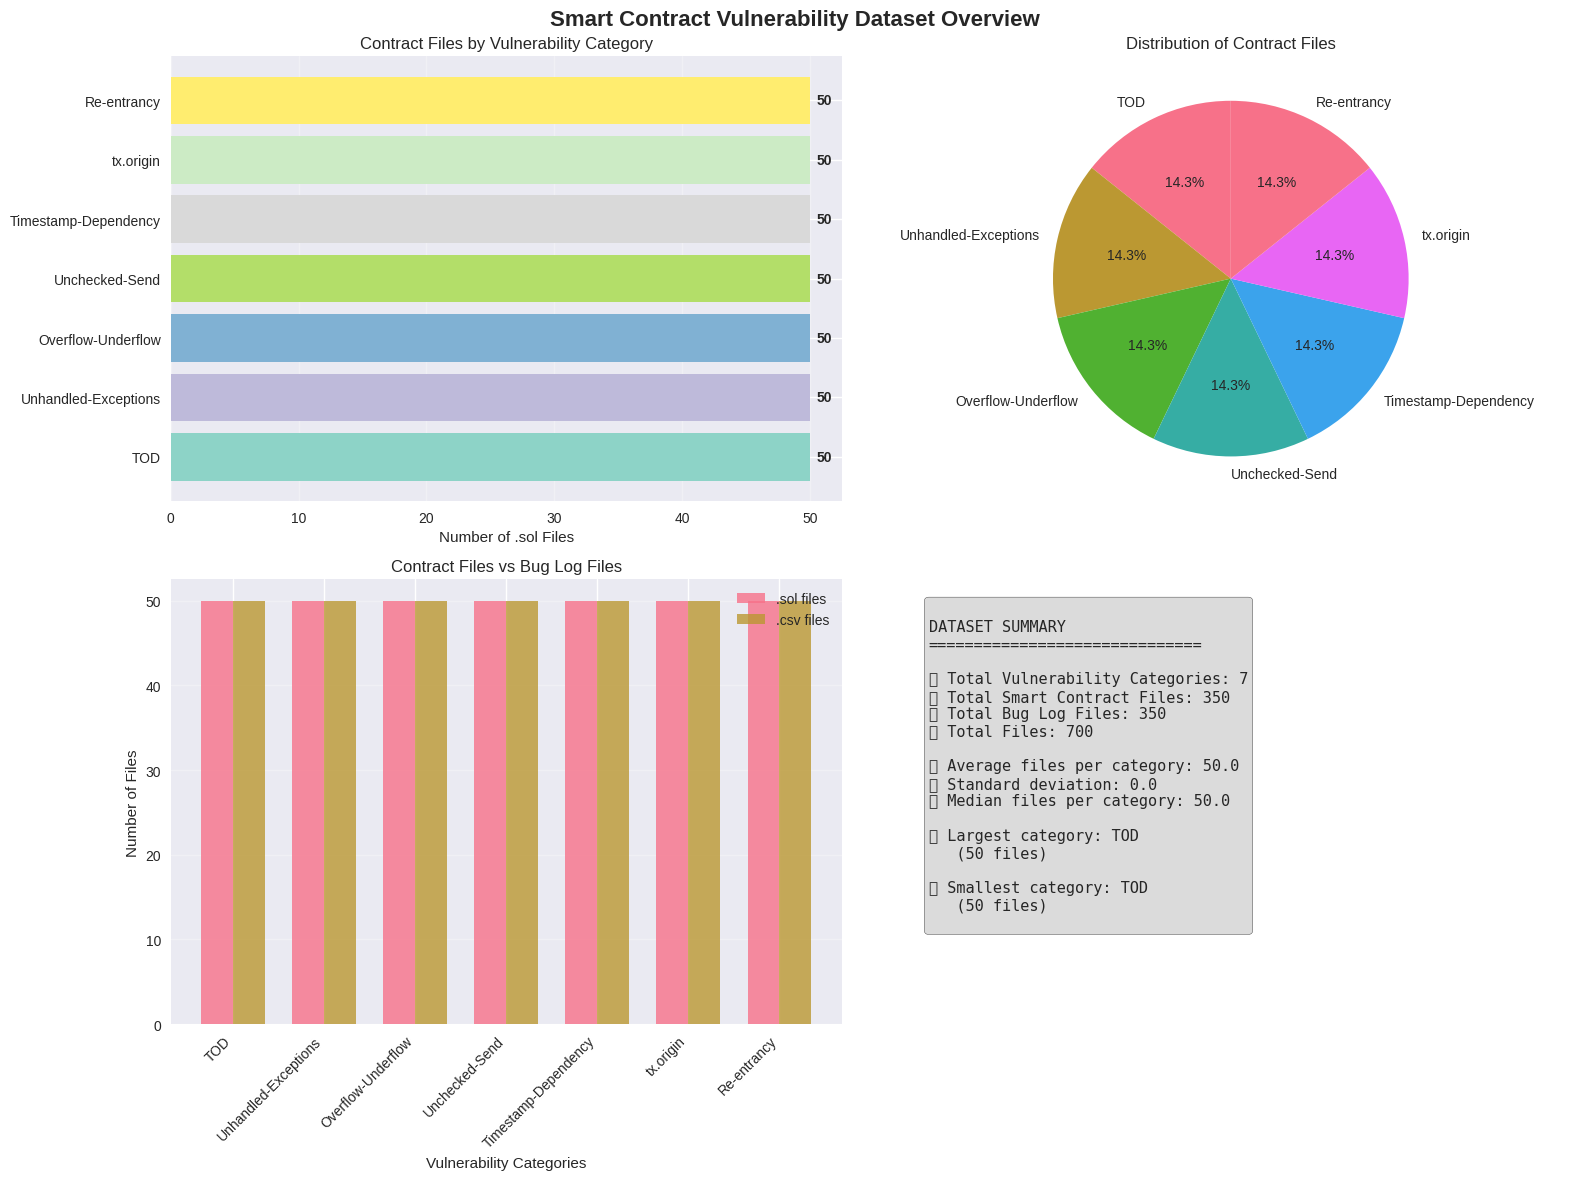

💾 Visualization saved to ../results/visualizations/dataset_overview.png


In [10]:
# Create necessary directories first
from pathlib import Path
Path('../results/visualizations').mkdir(parents=True, exist_ok=True)

# Create comprehensive visualization of vulnerability distribution
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Smart Contract Vulnerability Dataset Overview', fontsize=16, fontweight='bold')

# 1. Contract files by category (Bar plot)
stats_df_sorted = stats_df.sort_values('sol_files', ascending=True)
bars1 = ax1.barh(stats_df_sorted['Category'], stats_df_sorted['sol_files'], 
                 color=plt.cm.Set3(np.linspace(0, 1, len(stats_df_sorted))))
ax1.set_xlabel('Number of .sol Files')
ax1.set_title('Contract Files by Vulnerability Category')
ax1.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{int(width)}', ha='left', va='center', fontweight='bold')

# 2. Pie chart of distribution
wedges, texts, autotexts = ax2.pie(stats_df['sol_files'], labels=stats_df['Category'], 
                                  autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribution of Contract Files')

# 3. CSV vs SOL files comparison
x = np.arange(len(stats_df))
width = 0.35
bars3a = ax3.bar(x - width/2, stats_df['sol_files'], width, label='.sol files', alpha=0.8)
bars3b = ax3.bar(x + width/2, stats_df['csv_files'], width, label='.csv files', alpha=0.8)
ax3.set_xlabel('Vulnerability Categories')
ax3.set_ylabel('Number of Files')
ax3.set_title('Contract Files vs Bug Log Files')
ax3.set_xticks(x)
ax3.set_xticklabels(stats_df['Category'], rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Summary statistics
ax4.axis('off')
summary_text = f"""
DATASET SUMMARY
{'='*30}

📊 Total Vulnerability Categories: {len(vulnerability_categories)}
📄 Total Smart Contract Files: {stats_df['sol_files'].sum()}
📋 Total Bug Log Files: {stats_df['csv_files'].sum()}
📁 Total Files: {stats_df['total_files'].sum()}

📈 Average files per category: {stats_df['sol_files'].mean():.1f}
📊 Standard deviation: {stats_df['sol_files'].std():.1f}
🔢 Median files per category: {stats_df['sol_files'].median():.1f}

🏆 Largest category: {stats_df.loc[stats_df['sol_files'].idxmax(), 'Category']}
   ({stats_df['sol_files'].max()} files)

🏅 Smallest category: {stats_df.loc[stats_df['sol_files'].idxmin(), 'Category']}
   ({stats_df['sol_files'].min()} files)
"""
ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=11, 
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig('../results/visualizations/dataset_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Visualization saved to ../results/visualizations/dataset_overview.png")

## 4. Sample Contract Analysis

In [11]:
# Analyze sample contracts from different categories
def analyze_contract_file(file_path):
    """Analyze a single Solidity contract file"""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
        
        # Basic statistics
        lines = content.split('\n')
        stats = {
            'file_size_bytes': len(content),
            'total_lines': len(lines),
            'non_empty_lines': len([line for line in lines if line.strip()]),
            'comment_lines': len([line for line in lines if line.strip().startswith('//')]),
            'pragma_lines': len([line for line in lines if 'pragma' in line.lower()]),
            'contract_declarations': len(re.findall(r'contract\s+\w+', content)),
            'function_declarations': len(re.findall(r'function\s+\w+', content)),
            'event_declarations': len(re.findall(r'event\s+\w+', content)),
            'modifier_declarations': len(re.findall(r'modifier\s+\w+', content)),
        }
        
        return stats, content
    except Exception as e:
        return None, str(e)

# Sample analysis from each category
sample_analysis = {}

print("🔍 ANALYZING SAMPLE CONTRACTS")
print("="*50)

for category in vulnerability_categories[:3]:  # Analyze first 3 categories as examples
    category_path = buggy_contracts_dir / category
    sol_files = list(category_path.glob("*.sol"))[:2]  # Take first 2 files
    
    category_stats = []
    
    print(f"\n📂 {category}:")
    for sol_file in sol_files:
        stats, content = analyze_contract_file(sol_file)
        if stats:
            category_stats.append(stats)
            print(f"   📄 {sol_file.name}: {stats['total_lines']} lines, {stats['function_declarations']} functions")
    
    sample_analysis[category] = category_stats

🔍 ANALYZING SAMPLE CONTRACTS

📂 TOD:
   📄 buggy_43.sol: 732 lines, 93 functions
   📄 buggy_26.sol: 497 lines, 70 functions

📂 Unhandled-Exceptions:
   📄 buggy_43.sol: 434 lines, 64 functions
   📄 buggy_26.sol: 270 lines, 47 functions

📂 Overflow-Underflow:
   📄 buggy_43.sol: 472 lines, 71 functions
   📄 buggy_26.sol: 286 lines, 52 functions


In [12]:
# Display a sample contract from the first category
if vulnerability_categories:
    first_category = vulnerability_categories[0]
    first_category_path = buggy_contracts_dir / first_category
    sample_files = list(first_category_path.glob("*.sol"))[:1]
    
    if sample_files:
        sample_file = sample_files[0]
        _, content = analyze_contract_file(sample_file)
        
        print(f"📋 SAMPLE CONTRACT: {sample_file.name}")
        print(f"📂 Category: {first_category}")
        print("="*60)
        
        # Show first 30 lines
        lines = content.split('\n')[:30]
        for i, line in enumerate(lines, 1):
            print(f"{i:2d}: {line}")
        
        if len(content.split('\n')) > 30:
            print(f"... ({len(content.split('\n')) - 30} more lines)")
        
        print("\n" + "="*60)

📋 SAMPLE CONTRACT: buggy_43.sol
📂 Category: TOD
 1: /**
 2:  *Submitted for verification at Etherscan.io on 2019-09-24
 3: */
 4: 
 5: pragma solidity ^0.5.0;
 6: 
 7: 
 8: contract EventMetadata {
 9: 
10:   address payable winner_TOD33;
11: function play_TOD33(bytes32 guess) public{
12:  
13:        if (keccak256(abi.encode(guess)) == keccak256(abi.encode('hello'))) {
14: 
15:             winner_TOD33 = msg.sender;
16:         }
17:     }
18: 
19: function getReward_TOD33() payable public{
20:      
21:        winner_TOD33.transfer(msg.value);
22:     }
23:   event MetadataSet(bytes metadata);
24: 
25:     // state functions
26: 
27:     function _setMetadata(bytes memory metadata) internal {
28:         emit MetadataSet(metadata);
29:     }
30: bool claimed_TOD2 = false;
... (702 more lines)



## 5. Bug Log Analysis

In [13]:
# Analyze bug log files (CSV)
def analyze_bug_log(csv_path):
    """Analyze a bug log CSV file"""
    try:
        df = pd.read_csv(csv_path)
        return {
            'num_entries': len(df),
            'columns': list(df.columns),
            'sample_data': df.head().to_dict('records') if len(df) > 0 else []
        }
    except Exception as e:
        return {'error': str(e)}

print("🐛 BUG LOG ANALYSIS")
print("="*40)

# Analyze bug logs from first category
if vulnerability_categories:
    first_category = vulnerability_categories[0]
    first_category_path = buggy_contracts_dir / first_category
    csv_files = list(first_category_path.glob("*.csv"))[:3]  # Analyze first 3 CSV files
    
    for csv_file in csv_files:
        print(f"\n📊 Analyzing: {csv_file.name}")
        bug_log_stats = analyze_bug_log(csv_file)
        
        if 'error' not in bug_log_stats:
            print(f"   📈 Entries: {bug_log_stats['num_entries']}")
            print(f"   📋 Columns: {bug_log_stats['columns']}")
            
            # Show sample data if available
            if bug_log_stats['sample_data']:
                print("   📄 Sample data:")
                for i, entry in enumerate(bug_log_stats['sample_data'][:2]):
                    print(f"      Row {i+1}: {entry}")
        else:
            print(f"   ❌ Error: {bug_log_stats['error']}")

🐛 BUG LOG ANALYSIS

📊 Analyzing: BugLog_5.csv
   📈 Entries: 31
   📋 Columns: ['loc', 'length', 'bug type', 'approach']
   📄 Sample data:
      Row 1: {'loc': 542, 'length': 13, 'bug type': 'TOD', 'approach': 'code snippet injection'}
      Row 2: {'loc': 241, 'length': 13, 'bug type': 'TOD', 'approach': 'code snippet injection'}

📊 Analyzing: BugLog_12.csv
   📈 Entries: 37
   📋 Columns: ['loc', 'length', 'bug type', 'approach']
   📄 Sample data:
      Row 1: {'loc': 279, 'length': 13, 'bug type': 'TOD', 'approach': 'code snippet injection'}
      Row 2: {'loc': 215, 'length': 13, 'bug type': 'TOD', 'approach': 'code snippet injection'}

📊 Analyzing: BugLog_45.csv
   📈 Entries: 28
   📋 Columns: ['loc', 'length', 'bug type', 'approach']
   📄 Sample data:
      Row 1: {'loc': 118, 'length': 13, 'bug type': 'TOD', 'approach': 'code snippet injection'}
      Row 2: {'loc': 104, 'length': 13, 'bug type': 'TOD', 'approach': 'code snippet injection'}


## 6. Analysis Tools Results

In [14]:
# Explore analysis tool results
analysis_tools = []
if results_dir.exists():
    analysis_tools = [d.name for d in results_dir.iterdir() if d.is_dir()]

print("🔧 ANALYSIS TOOLS RESULTS")
print("="*40)

tool_stats = {}
for tool in analysis_tools:
    tool_path = results_dir / tool
    files = list(tool_path.glob("*"))
    
    tool_stats[tool] = {
        'total_files': len(files),
        'file_types': Counter([f.suffix for f in files if f.is_file()])
    }
    
    print(f"\n🛠️  {tool}:")
    print(f"   📁 Total files: {len(files)}")
    print(f"   📄 File types: {dict(tool_stats[tool]['file_types'])}")

print(f"\n📊 Total analysis tools: {len(analysis_tools)}")
if analysis_tools:
    print(f"🛠️  Tools: {', '.join(analysis_tools)}")

🔧 ANALYSIS TOOLS RESULTS

🛠️  Securify:
   📁 Total files: 1
   📄 File types: {}

🛠️  Slither:
   📁 Total files: 1
   📄 File types: {}

🛠️  Smartcheck:
   📁 Total files: 1
   📄 File types: {}

🛠️  Mythril:
   📁 Total files: 1
   📄 File types: {}

🛠️  Oyente:
   📁 Total files: 1
   📄 File types: {}

🛠️  Manticore:
   📁 Total files: 1
   📄 File types: {}

📊 Total analysis tools: 6
🛠️  Tools: Securify, Slither, Smartcheck, Mythril, Oyente, Manticore


## 7. Interactive Dataset Explorer

In [16]:
# Install nbformat if needed and create interactive visualization
try:
    import nbformat
except ImportError:
    import subprocess
    import sys
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'nbformat>=4.2.0'])

# Create interactive visualization using Plotly
# Interactive bar chart
fig_interactive = go.Figure()

fig_interactive.add_trace(go.Bar(
    x=stats_df['Category'],
    y=stats_df['sol_files'],
    name='Contract Files (.sol)',
    marker_color='lightblue',
    hovertemplate='<b>%{x}</b><br>Contract Files: %{y}<extra></extra>'
))

fig_interactive.add_trace(go.Bar(
    x=stats_df['Category'],
    y=stats_df['csv_files'],
    name='Bug Log Files (.csv)',
    marker_color='lightcoral',
    hovertemplate='<b>%{x}</b><br>Bug Log Files: %{y}<extra></extra>'
))

fig_interactive.update_layout(
    title='Interactive Dataset Overview',
    xaxis_title='Vulnerability Categories',
    yaxis_title='Number of Files',
    barmode='group',
    hovermode='x unified',
    height=500
)

# Try to show the plot, if it fails just save it
try:
    fig_interactive.show()
except:
    print("⚠️ Could not display interactive plot in notebook, but saving to file...")

# Ensure directory exists and save interactive plot
Path('../results/visualizations').mkdir(parents=True, exist_ok=True)
fig_interactive.write_html('../results/visualizations/interactive_dataset_overview.html')
print("💾 Interactive visualization saved to ../results/visualizations/interactive_dataset_overview.html")

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached fastjsonschema-2.21.2-py3-none-any.whl.metadata (2.3 kB)
  Using cached jsonschema-4.25.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached jsonschema_specifications-2025.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached referencing-0.37.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached jsonschema_specifications-2025.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached referencing-0.37.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached rpds_py-0.28.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached fastjsonschema-2.21.2-py3-none-any.whl (24 kB)
Using cached jsonschema-4.25.1-py3-none-any.whl (90 kB)
Using cached jsonschema_specifications-2025.9.1-py3-none-any.whl (18 kB)
Using cached referencing-0.37.0-py3-none-any.whl (26 kB)
  Using cached rpds_py-0.28.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x

## 8. Dataset Quality Assessment

In [17]:
# Comprehensive dataset quality assessment
quality_report = {
    'completeness': {},
    'consistency': {},
    'size_analysis': {},
    'recommendations': []
}

print("🔍 DATASET QUALITY ASSESSMENT")
print("="*50)

# 1. Completeness check
print("\n1️⃣ COMPLETENESS ANALYSIS")
print("-" * 30)

for category in vulnerability_categories:
    category_path = buggy_contracts_dir / category
    sol_count = len(list(category_path.glob("*.sol")))
    csv_count = len(list(category_path.glob("*.csv")))
    
    # Check if sol and csv counts match
    match_ratio = min(sol_count, csv_count) / max(sol_count, csv_count) if max(sol_count, csv_count) > 0 else 0
    
    quality_report['completeness'][category] = {
        'sol_files': sol_count,
        'csv_files': csv_count,
        'match_ratio': match_ratio
    }
    
    status = "✅" if match_ratio >= 0.9 else "⚠️" if match_ratio >= 0.7 else "❌"
    print(f"{status} {category}: {sol_count} .sol, {csv_count} .csv (match: {match_ratio:.1%})")

# 2. Size distribution analysis
print("\n2️⃣ SIZE DISTRIBUTION ANALYSIS")
print("-" * 35)

all_sizes = []
category_sizes = {}

for category in vulnerability_categories:
    category_path = buggy_contracts_dir / category
    sol_files = list(category_path.glob("*.sol"))
    
    sizes = []
    for sol_file in sol_files[:10]:  # Sample first 10 files
        try:
            size = sol_file.stat().st_size
            sizes.append(size)
            all_sizes.append(size)
        except:
            continue
    
    if sizes:
        category_sizes[category] = {
            'mean_size': np.mean(sizes),
            'median_size': np.median(sizes),
            'min_size': min(sizes),
            'max_size': max(sizes)
        }
        
        print(f"📊 {category}:")
        print(f"   Average: {np.mean(sizes):.0f} bytes")
        print(f"   Range: {min(sizes)}-{max(sizes)} bytes")

if all_sizes:
    print(f"\n📈 Overall statistics:")
    print(f"   Total files analyzed: {len(all_sizes)}")
    print(f"   Average file size: {np.mean(all_sizes):.0f} bytes")
    print(f"   Median file size: {np.median(all_sizes):.0f} bytes")
    print(f"   Size range: {min(all_sizes)}-{max(all_sizes)} bytes")

# 3. Recommendations
print("\n3️⃣ RECOMMENDATIONS")
print("-" * 20)

recommendations = []

# Check for imbalanced categories
sol_counts = [quality_report['completeness'][cat]['sol_files'] for cat in vulnerability_categories]
if max(sol_counts) / min(sol_counts) > 5:
    recommendations.append("⚠️ Consider data balancing - some categories have significantly more samples")

# Check for missing bug logs
incomplete_categories = [cat for cat in vulnerability_categories 
                        if quality_report['completeness'][cat]['match_ratio'] < 0.9]
if incomplete_categories:
    recommendations.append(f"🔧 Complete bug logs for: {', '.join(incomplete_categories)}")

# General recommendations
recommendations.extend([
    "✅ Dataset appears suitable for ML training",
    "📊 Consider stratified sampling for balanced training",
    "🔍 Validate contract compilation before training",
    "💾 Create preprocessed dataset cache for faster loading"
])

for rec in recommendations:
    print(rec)

quality_report['recommendations'] = recommendations

🔍 DATASET QUALITY ASSESSMENT

1️⃣ COMPLETENESS ANALYSIS
------------------------------
✅ TOD: 50 .sol, 50 .csv (match: 100.0%)
✅ Unhandled-Exceptions: 50 .sol, 50 .csv (match: 100.0%)
✅ Overflow-Underflow: 50 .sol, 50 .csv (match: 100.0%)
✅ Unchecked-Send: 50 .sol, 50 .csv (match: 100.0%)
✅ Timestamp-Dependency: 50 .sol, 50 .csv (match: 100.0%)
✅ tx.origin: 50 .sol, 50 .csv (match: 100.0%)
✅ Re-entrancy: 50 .sol, 50 .csv (match: 100.0%)

2️⃣ SIZE DISTRIBUTION ANALYSIS
-----------------------------------
📊 TOD:
   Average: 19534 bytes
   Range: 10811-48638 bytes
📊 Unhandled-Exceptions:
   Average: 13157 bytes
   Range: 6068-39572 bytes
📊 Overflow-Underflow:
   Average: 14818 bytes
   Range: 6803-41952 bytes
📊 Unchecked-Send:
   Average: 11228 bytes
   Range: 4904-35298 bytes
📊 Timestamp-Dependency:
   Average: 14311 bytes
   Range: 6921-41472 bytes
📊 tx.origin:
   Average: 13362 bytes
   Range: 6217-39126 bytes
📊 Re-entrancy:
   Average: 17243 bytes
   Range: 8903-45233 bytes

📈 Overall

## 9. Save Dataset Summary

In [19]:
# Create necessary directories first
Path('../data/processed').mkdir(parents=True, exist_ok=True)
Path('../outputs').mkdir(parents=True, exist_ok=True)

# Convert numpy types to Python types for JSON serialization
def convert_numpy_types(obj):
    """Convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(v) for v in obj]
    elif hasattr(obj, 'item'):  # numpy scalar
        return obj.item()
    else:
        return obj

# Create comprehensive dataset summary
dataset_summary = {
    'overview': {
        'total_categories': len(vulnerability_categories),
        'vulnerability_categories': vulnerability_categories,
        'total_sol_files': int(stats_df['sol_files'].sum()),
        'total_csv_files': int(stats_df['csv_files'].sum()),
        'analysis_tools': analysis_tools
    },
    'category_statistics': convert_numpy_types(stats_df.to_dict('records')),
    'quality_assessment': convert_numpy_types(quality_report),
    'file_size_statistics': {
        'mean_size_bytes': float(np.mean(all_sizes)) if all_sizes else 0,
        'median_size_bytes': float(np.median(all_sizes)) if all_sizes else 0,
        'min_size_bytes': int(min(all_sizes)) if all_sizes else 0,
        'max_size_bytes': int(max(all_sizes)) if all_sizes else 0
    }
}

# Save summary to JSON
with open('../data/processed/dataset_summary.json', 'w') as f:
    json.dump(dataset_summary, f, indent=2)

# Save detailed stats to CSV
stats_df.to_csv('../data/processed/category_statistics.csv', index=False)

print("💾 Dataset summary saved to:")
print("   📄 ../data/processed/dataset_summary.json")
print("   📊 ../data/processed/category_statistics.csv")

# Display final summary
print("\n" + "="*60)
print("🎯 DATASET ACQUISITION AND OVERVIEW COMPLETE!")
print("="*60)

summary_text = f"""
📊 FINAL SUMMARY:
• {len(vulnerability_categories)} vulnerability categories identified
• {stats_df['sol_files'].sum()} smart contract files (.sol)
• {stats_df['csv_files'].sum()} bug log files (.csv)
• {len(analysis_tools)} analysis tools with results
• Average {stats_df['sol_files'].mean():.1f} contracts per category
• Dataset quality: {'Good' if len([cat for cat in vulnerability_categories if quality_report['completeness'][cat]['match_ratio'] >= 0.9]) > len(vulnerability_categories) * 0.7 else 'Needs attention'}

🚀 READY FOR NEXT STEPS:
• Preprocessing and function extraction
• Feature engineering and tokenization
• Model training and evaluation

📁 Generated Files:
• Dataset summary and statistics
• Visualization plots
• Quality assessment report
"""

print(summary_text)

# Save this summary too
with open('../outputs/data_acquisition_summary.txt', 'w') as f:
    f.write(summary_text)

print("💾 Summary also saved to ../outputs/data_acquisition_summary.txt")
print("\n🎯 Ready to proceed to notebook 02: Preprocessing and Function Extraction!")

💾 Dataset summary saved to:
   📄 ../data/processed/dataset_summary.json
   📊 ../data/processed/category_statistics.csv

🎯 DATASET ACQUISITION AND OVERVIEW COMPLETE!

📊 FINAL SUMMARY:
• 7 vulnerability categories identified
• 350 smart contract files (.sol)
• 350 bug log files (.csv)
• 6 analysis tools with results
• Average 50.0 contracts per category
• Dataset quality: Good

🚀 READY FOR NEXT STEPS:
• Preprocessing and function extraction
• Feature engineering and tokenization
• Model training and evaluation

📁 Generated Files:
• Dataset summary and statistics
• Visualization plots
• Quality assessment report

💾 Summary also saved to ../outputs/data_acquisition_summary.txt

🎯 Ready to proceed to notebook 02: Preprocessing and Function Extraction!
